In [2]:
%load_ext autoreload
%autoreload 2

# Add parent directory into system path
import sys, os
sys.path.insert(1, os.path.abspath(os.path.normpath('..')))

import numpy as np
from sdf import *

@sdf3
def gyroid(w = 3.14159, t=0):
    def f(p):
        q = w*p
        x, y, z = (q[:, i] for i in range(3))
        return (np.cos(x)*np.sin(y) + np.cos(y)*np.sin(z) + np.cos(z)*np.sin(x) - t)
    return f

In [3]:
# Generate with skimage.measure.marching_cubes
f = sphere(1) & gyroid(w=12)
points = f.generate(step=0.01, verbose=True, method=1)
#write_binary_stl('gyroid_w12.stl', points)

min -1.17859, -1.17859, -1.17859
max 1.17859, 1.17859, 1.17859
step 0.01, 0.01, 0.01

960900 triangles in 1.74309 seconds


In [14]:
from sdf.mesh import _cartesian_product, _estimate_bounds
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import CenteredNorm
from matplotlib.ticker import FuncFormatter

def show_sdf_at_z(f, z_level=0, step=0.01, offset=30, nums=100):
    dx, dy, dz = (step,)*3
    bounds = _estimate_bounds(f)
    (x0, y0, z0), (x1, y1, z1) = bounds


    # X = np.arange(x0-offset*dx, x1+offset*dx, dx)
    # Y = np.arange(y0-offset*dy, y1+offset*dy, dy)
    # Z = np.arange(z0-offset*dz, z1+offset*dz, dz)

    X = np.linspace(x0-offset*dx, x1+offset*dx, nums)
    Y = np.linspace(y0-offset*dy, y1+offset*dy, nums)
    Z = np.array([z_level])

    P = _cartesian_product(X, Y, Z)
    sdf = -f(P)
    sdf = sdf.reshape((nums, nums))

    print('Local: ', np.min(sdf), np.max(sdf))
    

    fig, ax = plt.subplots()
    plt.pcolormesh(sdf, cmap='coolwarm', norm=CenteredNorm())
    plt.colorbar()
    ax.set_title('min=%.6f max=%.6f' % (np.min(sdf), np.max(sdf)))
    ax.tick_params(axis='both', which='major', labelsize=6)
    #c.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x:,.2f}'))
    #c.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x:,.2f}'))
    plt.show()

Local:  -0.5172091167070509 0.2


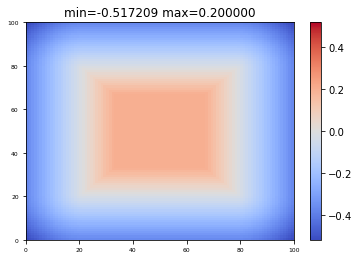

Local:  -0.5891060063000148 0.24152470283729222


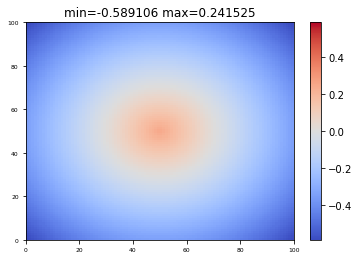

Local:  -0.5524369512322742 0.1602217442701377


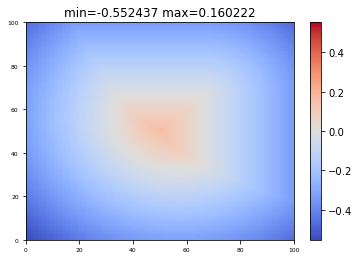

In [15]:
show_sdf_at_z(box(1), 0.3)
show_sdf_at_z((box(1) & sphere(0.25)), 0)
show_sdf_at_z(sphere(0.25, center=[0.4, 0.4, 0]) & box(1), 0)

Local:  -1.4135129759784182 0.47376637359657714


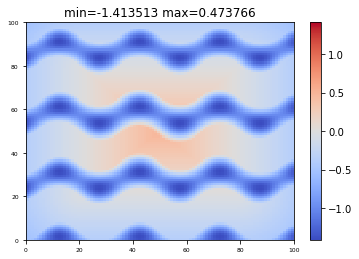

In [16]:
show_sdf_at_z(box(1) & gyroid(w=12), 0, step=0.01)